## Select the fundamental architecture for the LV models.
    * choose the rank of the cc matrix (ss1 / ss2 / ss3)
## Evaluate based on:
    * quality of d-prime predictions
    * quality of cc predictions
Idea is that quality of cc predictions will go up with higher rank models, but 
prediction of d-prime might not. Because dDR selects a slightly different space 
for each stimulus pair, I think we can make this argument without increasing the 
dDR dimensionality, but I'm not sure...


In [1]:
import sys; sys.path.append("/auto/users/hellerc/code/projects/nat_pupil_ms/")
from global_settings import CPN_SITES, HIGHR_SITES
from path_settings import DPRIME_DIR
import charlieTools.nat_sounds_ms.decoding as decoding
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob

import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 14

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-12-29 094819.log


In [2]:
# load LV model results
recache = False
rank = ["ss1", "ss2", "ss3"]
# allPup only for low rep count data where can't really do full cross-val
decoders = [
    'dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-dU',
    'dprime_jk10_zscore_allPup_fixtdr2-fa',
    'dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-1',
    'dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-2'
]
models = {
    "rlv": 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0', 
    "ind": 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.SxR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0', 
    "plv": 'psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0', 
    "plv2": 'psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0'
}
gresults = dict.fromkeys(decoders)
for decoder in decoders:
    cache_file = f"/auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/results_{decoder}.pickle"
    if os.path.isfile(cache_file) & (recache==False):
        #load from cache
        print(f"Loading results from cache {cache_file}")
        with open(cache_file, 'rb') as handle:
            results = pickle.load(handle)
    else:
        sites = CPN_SITES + HIGHR_SITES
        batches = [331]*len(CPN_SITES) + [322 if s not in ["BOL005c", "BOL006b"] else 294 for s in HIGHR_SITES]
        results = dict.fromkeys(rank)
        fitc = {}
        valc = {}
        for ii, ss in enumerate(rank):
            results[ss] = dict.fromkeys(models.keys())
            results[ss]["raw"] = {
                "fit": [],
                "val": []
            }
            for jj, (k, m) in enumerate(models.items()): 
                results[ss][k] = {
                    "fit": [],
                    "val": []
                }
                m = m.replace("f0", f"f0.{ss}")
                for batch, site in zip(batches, sites):            
                    if batch != 331:
                        mn = m.replace("-epcpn", "")
                        d = decoder
                    else:
                        d = decoder.replace("_allPup", "")
                        mn = m
                    loader = decoding.DecodingResults()
                    fn = os.path.join(DPRIME_DIR, str(batch), site, d+f'_model-LV-{mn}_TDR.pickle')
                    res = loader.load_results(fn)
                    # get the epochs of interest (fit epochs)
                    mask_bins = res.meta['mask_bins']
                    fit_combos = [k for k, v in res.mapping.items() if (('_'.join(v[0].split('_')[:-1]), int(v[0].split('_')[-1])) in mask_bins) & \
                                                                        (('_'.join(v[1].split('_')[:-1]), int(v[1].split('_')[-1])) in mask_bins)]
                    all_combos = res.evoked_stimulus_pairs
                    val_combos = [c for c in all_combos if c not in fit_combos]
                    df = res.numeric_results
                    df["delta_dprime"] = (df['bp_dp'] - df['sp_dp']) / (df['bp_dp'] + df['sp_dp'])
                    df["delta_dprime_raw"] = (df['bp_dp'] - df['sp_dp'])
                    df["site"] = site
                    df["batch"] = batch
                    results[ss][k]["fit"].append(df.loc[fit_combos])
                    results[ss][k]["val"].append(df.loc[val_combos])
                    if ii==jj==0:
                        fitc[site+str(batch)] = fit_combos
                        valc[site+str(batch)] = val_combos
                    else:
                        if fitc[site+str(batch)] != fit_combos:
                            raise ValueError("what the fuck is up")

            # load raw results
            for batch, site in zip(batches, sites):            
                if batch != 331:
                    mn = m.replace("-epcpn", "")
                    d = decoder
                else:
                    d = decoder.replace("_allPup", "")
                    mn = m
                loader = decoding.DecodingResults()
                fn = os.path.join(DPRIME_DIR, str(batch), site, d+'_TDR.pickle')
                res = loader.load_results(fn)
                # get the epochs of interest (fit epochs)
                df = res.numeric_results
                df["delta_dprime"] = (df['bp_dp'] - df['sp_dp']) / (df['bp_dp'] + df['sp_dp'])
                df["delta_dprime_raw"] = (df['bp_dp'] - df['sp_dp'])
                df["site"] = site
                df["batch"] = batch
                if df.loc[fitc[site+str(batch)]].shape[0] != len(fitc[site+str(batch)]):
                    raise ValueError(f"What the fuck. Site: {site}")
                results[ss]["raw"]["fit"].append(df.loc[fitc[site+str(batch)]])
                results[ss]["raw"]["val"].append(df.loc[valc[site+str(batch)]])
        for ii, ss in enumerate(rank):
            for jj, (k, m) in enumerate(models.items()):
                results[ss][k]["fit"] = pd.concat(results[ss][k]["fit"])
                results[ss][k]["val"] = pd.concat(results[ss][k]["val"])
            results[ss]["raw"]["fit"] = pd.concat(results[ss]["raw"]["fit"])
            results[ss]["raw"]["val"] = pd.concat(results[ss]["raw"]["val"])
        with open(cache_file, 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(f"\n loaded results for {decoder} \n")
    gresults[decoder] = results

Loading results from cache /auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/results_dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-dU.pickle

 loaded results for dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-dU 

Loading results from cache /auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/results_dprime_jk10_zscore_allPup_fixtdr2-fa.pickle

 loaded results for dprime_jk10_zscore_allPup_fixtdr2-fa 

Loading results from cache /auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/results_dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-1.pickle

 loaded results for dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-1 

Loading results from cache /auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/results_dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-2.pickle

 loaded results for dprime_jk10_zscore_allPup_fixtdr2-fa_noiseDim-2 



In [3]:
metric = "delta_dprime"
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]
batches = [331, 322]
for decoder in decoders:
    f, ax = plt.subplots(1, len(rank), figsize=(18, 6), sharey=True)
    #fcc, axc = plt.subplots(1, len(rank), figsize=(18, 6), sharey=True)
    for sbp, ss in enumerate(rank):
        print(f"Model rank {ss}")
        err = {}
        cc_dist = {}
        for xtick, (k, col) in enumerate(zip(models.keys(), colors)):
            res = gresults[decoder][ss][k]["fit"]; res = res[res.batch.isin(batches)]; res.loc[:, "exp"] = [str(res.iloc[i]["batch"])+res.iloc[i]["site"] for i in range(res.shape[0])]
            raw = gresults[decoder][ss]["raw"]["fit"]; raw = raw[raw.batch.isin(batches)]; raw.loc[:, "exp"] = [str(raw.iloc[i]["batch"])+raw.iloc[i]["site"] for i in range(raw.shape[0])]
            diff = np.median(np.abs(res[metric].values-raw[metric].values))
            err[k] = np.abs(res[metric].values-raw[metric].values)
            ax[sbp].plot(xtick, diff, 'o', color=col)
            d = {s: np.abs(raw[raw.exp==s][metric]-res[res.exp==s][metric]).values for s in raw.exp.unique()}
            bootsamp = get_bootstrapped_sample(d, metric='median', even_sample=False, nboot=1000)
            low = np.quantile(bootsamp, .025)
            high = np.quantile(bootsamp, .975)
            ax[sbp].plot([xtick, xtick], [low, high], color=col, zorder=-1)
            ax[sbp].grid(axis="y", color="grey", which="major", zorder=-1)
            ax[sbp].set_title(ss)

            # cc = np.corrcoef(res[metric], raw[metric])[0, 1]
            # d = {s: raw[raw.exp==s][metric].values for s in raw.exp.unique()}
            # d2 = {s: res[res.exp==s][metric].values for s in raw.exp.unique()}
            # bootsamp = get_bootstrapped_sample(d, d2, metric='corrcoef', even_sample=False, nboot=1000)
            # low = np.quantile(bootsamp, .025)
            # high = np.quantile(bootsamp, .975)
            # axc[sbp].plot(xtick, cc, 'o', color=col)
            # axc[sbp].plot([xtick, xtick], [low, high], color=col, zorder=-1)
            # axc[sbp].grid(axis="y", color="grey", which="major", zorder=-1)
            # axc[sbp].set_title(ss)

        exp = raw.exp.values
        keys = list(models.keys())
        for xtick, k in enumerate(list(models.keys())[:-1]):
            d = {e: err[k][exp==e] - err[keys[xtick+1]][exp==e] for e in raw.exp.unique()} 
            bootsample = get_bootstrapped_sample(d, metric="median", even_sample=False, nboot=1000) 
            p = get_direct_prob(bootsample, np.zeros(len(bootsample)))[0]
            ax[sbp].text(xtick+0.5, ax[sbp].get_ylim()[1], f'p={round(p, 3)}', fontsize=8)  

/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Model rank ss1
Model rank ss2
Model rank ss3
Model rank ss1
Model rank ss2
Model rank ss3
Model rank ss1


## Evaluate LV model performance based on predictions of cc matrices

In [5]:
from nems.xform_helper import load_model_xform
import nems.db as nd

In [6]:
def cc_comp(r, extra_epoch):
    rec = r.apply_mask()
    if type(extra_epoch) is list:
        for i, e in enumerate(extra_epoch):
            if i == 0:
                large_idx=rec['mask_'+e+'_lg'].as_continuous()[0,:].astype(bool)
                small_idx=rec['mask_'+e+'_sm'].as_continuous()[0,:].astype(bool)
            else:
                li = rec['mask_'+e+'_lg'].as_continuous()[0,:].astype(bool)
                si = rec['mask_'+e+'_sm'].as_continuous()[0,:].astype(bool)
                large_idx += li
                small_idx += si
    else:
        large_idx=rec['mask_'+extra_epoch+'_lg'].as_continuous()[0,:].astype(bool)
        small_idx=rec['mask_'+extra_epoch+'_sm'].as_continuous()[0,:].astype(bool)
    print(f"masked {extra_epoch} len from {rec['mask'].as_continuous().sum()} to {large_idx.sum()+small_idx.sum()}")

    input_name = 'pred0'

    pred0 = rec[input_name].as_continuous()
    pred = rec['pred'].as_continuous()
    resp = rec['resp'].as_continuous()
    state = rec['state'].as_continuous()

    large_cc = np.cov(resp[:,large_idx]-pred0[:,large_idx])
    small_cc = np.cov(resp[:,small_idx]-pred0[:,small_idx])
    sm_cc = np.cov(pred[:,small_idx]-pred0[:,small_idx])
    lg_cc = np.cov(pred[:,large_idx]-pred0[:,large_idx])
    all_cc = np.cov(resp[:,large_idx|small_idx]-pred0[:,large_idx|small_idx])
    allp_cc = np.cov(pred[:,large_idx|small_idx]-pred0[:,large_idx|small_idx])

    delta_err_up = np.mean((np.triu(large_cc-small_cc, 1) - np.triu(lg_cc-sm_cc, 1))**2)
    delta_err_diag = np.mean((np.diag(large_cc-small_cc) - np.diag(lg_cc-sm_cc))**2)

    lg_err_up = np.mean((np.triu(large_cc, 1) - np.triu(lg_cc, 1))**2)
    lg_err_diag = np.mean((np.diag(large_cc) - np.diag(lg_cc))**2)

    sm_err_up = np.mean((np.triu(small_cc, 1) - np.triu(sm_cc, 1))**2)
    sm_err_diag = np.mean((np.diag(small_cc) - np.diag(sm_cc))**2)

    avg_err_up = np.mean((np.triu(all_cc, 1) - np.triu(allp_cc, 1))**2)
    avg_err_diag = np.mean((np.diag(all_cc) - np.diag(allp_cc))**2)

    err = {
        "delta_err_up": delta_err_up,
        "delta_err_diag": delta_err_diag,
        "lg_err_up": lg_err_up,
        "lg_err_diag": lg_err_diag,
        "sm_err_up": sm_err_up,
        "sm_err_diag": sm_err_diag,
        "avg_err_up": avg_err_up,
        "avg_err_diag": avg_err_diag
    }

    return err

In [8]:
import copy
import pickle
from nems_lbhb.baphy_io import parse_cellid
recache = True
gpShuf = False
model_rank = "ss1"
if gpShuf:
    fn = "/auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/model_errs_gpShuf.pickle"
else:
    fn = "/auto/users/hellerc/code/projects/nat_pupil_ms/normative_LV_model/model_errs.pickle"
if recache:
    sites = CPN_SITES + HIGHR_SITES
    batches = [331]*len(CPN_SITES) + [322 if s not in ["BOL005c", "BOL006b"] else 294 for s in HIGHR_SITES]
    _e = {
        "lg_err": {"off": [], "diag": []},
        "sm_err": {"off": [], "diag": []},
        "diff_err": {"off": [], "diag": []},
        "avg_err": {"off": [], "diag": []}
    }
    errs = {mn: copy.deepcopy(_e) for mn in models} 
    for batch, site in zip(batches, sites):
        for mn, m in models.items():
            if batch in [294, 322]:
                m = m.replace("-epcpn", "")
            if gpShuf:
                m = m.replace("pup0", "pupGP").replace("pvp0", "pvpGP")

            m = m.replace(".f0", f".f0.{model_rank}")
            
            cells, ops = parse_cellid({"batch": batch, "cellid": site})
            xf, ctx = load_model_xform(modelname=m, batch=batch, cellid=cells[0], only=slice(0,16), eval_model=False)
            extra_epochs = [':'.join([e[0], str(e[1])]) for e in ctx["val"].meta['mask_bins']]
            err = cc_comp(ctx["val"], extra_epochs)
            errs[mn]["lg_err"]["off"].append(err["lg_err_up"])
            errs[mn]["sm_err"]["off"].append(err["sm_err_up"])
            errs[mn]["diff_err"]["off"].append(err["delta_err_up"])
            errs[mn]["avg_err"]["off"].append(err["avg_err_up"])
            errs[mn]["lg_err"]["diag"].append(err["lg_err_diag"])
            errs[mn]["sm_err"]["diag"].append(err["sm_err_diag"])
            errs[mn]["diff_err"]["diag"].append(err["delta_err_diag"])
            errs[mn]["avg_err"]["diag"].append(err["avg_err_diag"])

    with open(fn, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(fn, 'rb') as handle:
        errs = pickle.load(handle)

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT020a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...7387690425090462837 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz to /auto/data/nems_db/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2'

masked ['STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT020a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-8338044722597674073 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz to /auto/data/nems_db/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2

masked ['STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT020a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-4433516344307494541 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz to /auto/data/nems_db/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2

masked ['STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT020a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...4370470698705176552 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz to /auto/data/nems_db/recordings/331/AMT020a_eb4a1abbdccff095212f099664ec974b7cff14a4.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2'

masked ['STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT026a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...153711909293297877 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz to /auto/data/nems_db/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT026a-01-3', 'AMT026a-04-3', 'AMT026a-04-4', 'AMT026a-06-3', 'AMT026a-06-4', 'AMT026a-07-1', 'AMT026a-12-1', 'AMT026a-13-3', 'AMT026a-13-4', 'AMT026a-14-3', 'AMT026a-18-1', 'AMT026a-19-1', 'AMT026a-22-3', 'AMT026a-22-4', 'AMT026a-22-5', 'AMT026a-22-6', 'AMT026a-27-1',

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:0', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0'] len from 7680 to 3200


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT026a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...1244453667293570031 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz to /auto/data/nems_db/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT026a-01-3', 'AMT026a-04-3', 'AMT026a-04-4', 'AMT026a-06-3', 'AMT026a-06-4', 'AMT026a-07-1', 'AMT026a-12-1', 'AMT026a-13-3', 'AMT026a-13-4', 'AMT026a-14-3', 'AMT026a-18-1', 'AMT026a-19-1', 'AMT026a-22-3', 'AMT026a-22-4', 'AMT026a-22-5', 'AMT026a-22-6', 'AMT026a-27-1'

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:0', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0'] len from 7680 to 3200


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT026a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...8656954135597846214 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz to /auto/data/nems_db/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT026a-01-3', 'AMT026a-04-3', 'AMT026a-04-4', 'AMT026a-06-3', 'AMT026a-06-4', 'AMT026a-07-1', 'AMT026a-12-1', 'AMT026a-13-3', 'AMT026a-13-4', 'AMT026a-14-3', 'AMT026a-18-1', 'AMT026a-19-1', 'AMT026a-22-3', 'AMT026a-22-4', 'AMT026a-22-5', 'AMT026a-22-6', 'AMT026a-27-1'

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:0', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0'] len from 7680 to 3200


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/AMT026a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-7391721376985374029 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz to /auto/data/nems_db/recordings/331/AMT026a_a849bc1b691a6d84f236c1664befc457c44b24e7.tgz
[nems.xforms INFO] Extracting cellid(s) ['AMT026a-01-3', 'AMT026a-04-3', 'AMT026a-04-4', 'AMT026a-06-3', 'AMT026a-06-4', 'AMT026a-07-1', 'AMT026a-12-1', 'AMT026a-13-3', 'AMT026a-13-4', 'AMT026a-14-3', 'AMT026a-18-1', 'AMT026a-19-1', 'AMT026a-22-3', 'AMT026a-22-4', 'AMT026a-22-5', 'AMT026a-22-6', 'AMT026a-27-1

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:0', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0'] len from 7680 to 3200


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM029a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...7970301973867519918 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz to /auto/data/nems_db/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM029a-09-6', 'ARM029a-12-5', 'ARM029a-13-7', 'ARM029a-13-8', 'ARM029a-13-9', 'ARM029a-15-1', 'ARM029a-19-5', 'ARM029a-22-2', 'ARM029a-23-1', 'ARM029a-25-8', 'ARM029a-25-9', 'ARM029a-34-4', 'ARM029a-37-6', 'ARM029a-40-4', 'ARM029a-43-4', 'ARM029a-50-2', 'ARM029a-54-3'

masked ['STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:2', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM029a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-8293245836114574971 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz to /auto/data/nems_db/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM029a-09-6', 'ARM029a-12-5', 'ARM029a-13-7', 'ARM029a-13-8', 'ARM029a-13-9', 'ARM029a-15-1', 'ARM029a-19-5', 'ARM029a-22-2', 'ARM029a-23-1', 'ARM029a-25-8', 'ARM029a-25-9', 'ARM029a-34-4', 'ARM029a-37-6', 'ARM029a-40-4', 'ARM029a-43-4', 'ARM029a-50-2', 'ARM029a-54-3

masked ['STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:2', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM029a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-4979810206043225882 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz to /auto/data/nems_db/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM029a-09-6', 'ARM029a-12-5', 'ARM029a-13-7', 'ARM029a-13-8', 'ARM029a-13-9', 'ARM029a-15-1', 'ARM029a-19-5', 'ARM029a-22-2', 'ARM029a-23-1', 'ARM029a-25-8', 'ARM029a-25-9', 'ARM029a-34-4', 'ARM029a-37-6', 'ARM029a-40-4', 'ARM029a-43-4', 'ARM029a-50-2', 'ARM029a-54-3

masked ['STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:2', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM029a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...6767480055864273600 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz to /auto/data/nems_db/recordings/331/ARM029a_c378eb62b80907fbd8f188e93f323f4aefe85efc.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM029a-09-6', 'ARM029a-12-5', 'ARM029a-13-7', 'ARM029a-13-8', 'ARM029a-13-9', 'ARM029a-15-1', 'ARM029a-19-5', 'ARM029a-22-2', 'ARM029a-23-1', 'ARM029a-25-8', 'ARM029a-25-9', 'ARM029a-34-4', 'ARM029a-37-6', 'ARM029a-40-4', 'ARM029a-43-4', 'ARM029a-50-2', 'ARM029a-54-3'

masked ['STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:2', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:13_cat592_rec1_pouring_cereal_excerpt1_13:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM031a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-1457582011534745519 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz to /auto/data/nems_db/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM031a-06-3', 'ARM031a-08-3', 'ARM031a-09-2', 'ARM031a-09-3', 'ARM031a-13-3', 'ARM031a-13-4', 'ARM031a-14-1', 'ARM031a-15-2', 'ARM031a-17-2', 'ARM031a-18-3', 'ARM031a-18-4', 'ARM031a-19-1', 'ARM031a-21-6', 'ARM031a-21-7', 'ARM031a-21-8', 'ARM031a-24-10', 'ARM031a-24-

masked ['STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM031a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-2138400362172658113 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz to /auto/data/nems_db/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM031a-06-3', 'ARM031a-08-3', 'ARM031a-09-2', 'ARM031a-09-3', 'ARM031a-13-3', 'ARM031a-13-4', 'ARM031a-14-1', 'ARM031a-15-2', 'ARM031a-17-2', 'ARM031a-18-3', 'ARM031a-18-4', 'ARM031a-19-1', 'ARM031a-21-6', 'ARM031a-21-7', 'ARM031a-21-8', 'ARM031a-24-10', 'ARM031a-24-

masked ['STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM031a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...8418124376767576509 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz to /auto/data/nems_db/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM031a-06-3', 'ARM031a-08-3', 'ARM031a-09-2', 'ARM031a-09-3', 'ARM031a-13-3', 'ARM031a-13-4', 'ARM031a-14-1', 'ARM031a-15-2', 'ARM031a-17-2', 'ARM031a-18-3', 'ARM031a-18-4', 'ARM031a-19-1', 'ARM031a-21-6', 'ARM031a-21-7', 'ARM031a-21-8', 'ARM031a-24-10', 'ARM031a-24-7

masked ['STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM031a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...4443443523250292718 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz to /auto/data/nems_db/recordings/331/ARM031a_2f67721081c1838c5b637ed84c862edabee08d67.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM031a-06-3', 'ARM031a-08-3', 'ARM031a-09-2', 'ARM031a-09-3', 'ARM031a-13-3', 'ARM031a-13-4', 'ARM031a-14-1', 'ARM031a-15-2', 'ARM031a-17-2', 'ARM031a-18-3', 'ARM031a-18-4', 'ARM031a-19-1', 'ARM031a-21-6', 'ARM031a-21-7', 'ARM031a-21-8', 'ARM031a-24-10', 'ARM031a-24-7

masked ['STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:01_cat66_rec1_cash_register_excerpt1_1:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM032a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-9139079838811346484 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz to /auto/data/nems_db/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM032a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-3084577929060702657 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz to /auto/data/nems_db/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM032a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-8552489709413376784 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz to /auto/data/nems_db/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM032a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...4310145329728515471 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz to /auto/data/nems_db/recordings/331/ARM032a_dce9bc4a3508d265b9e93d6607a7d4d37bf30a4b.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7'

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM033a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...3215184800473924164 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz to /auto/data/nems_db/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM033a-02-1', 'ARM033a-05-2', 'ARM033a-06-1', 'ARM033a-29-1', 'ARM033a-29-2', 'ARM033a-30-1', 'ARM033a-30-2', 'ARM033a-34-2', 'ARM033a-36-2', 'ARM033a-36-3', 'ARM033a-43-1', 'ARM033a-45-1', 'ARM033a-46-2', 'ARM033a-48-2', 'ARM033a-49-2', 'ARM033a-51-3', 'ARM033a-53-1'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM033a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-6216051448660508106 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz to /auto/data/nems_db/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM033a-02-1', 'ARM033a-05-2', 'ARM033a-06-1', 'ARM033a-29-1', 'ARM033a-29-2', 'ARM033a-30-1', 'ARM033a-30-2', 'ARM033a-34-2', 'ARM033a-36-2', 'ARM033a-36-3', 'ARM033a-43-1', 'ARM033a-45-1', 'ARM033a-46-2', 'ARM033a-48-2', 'ARM033a-49-2', 'ARM033a-51-3', 'ARM033a-53-1

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM033a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...3729760936480083599 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz to /auto/data/nems_db/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM033a-02-1', 'ARM033a-05-2', 'ARM033a-06-1', 'ARM033a-29-1', 'ARM033a-29-2', 'ARM033a-30-1', 'ARM033a-30-2', 'ARM033a-34-2', 'ARM033a-36-2', 'ARM033a-36-3', 'ARM033a-43-1', 'ARM033a-45-1', 'ARM033a-46-2', 'ARM033a-48-2', 'ARM033a-49-2', 'ARM033a-51-3', 'ARM033a-53-1'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/ARM033a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-9166633554460365572 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz to /auto/data/nems_db/recordings/331/ARM033a_92a3e436bf9a1abf0441747a7d2005840534421f.tgz
[nems.xforms INFO] Extracting cellid(s) ['ARM033a-02-1', 'ARM033a-05-2', 'ARM033a-06-1', 'ARM033a-29-1', 'ARM033a-29-2', 'ARM033a-30-1', 'ARM033a-30-2', 'ARM033a-34-2', 'ARM033a-36-2', 'ARM033a-36-3', 'ARM033a-43-1', 'ARM033a-45-1', 'ARM033a-46-2', 'ARM033a-48-2', 'ARM033a-49-2', 'ARM033a-51-3', 'ARM033a-53-1

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:0'] len from 9600 to 4000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/CRD018d/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...9111809569548236955 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz to /auto/data/nems_db/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz
[nems.xforms INFO] Extracting cellid(s) ['CRD018d-01-1', 'CRD018d-05-1', 'CRD018d-10-2', 'CRD018d-10-3', 'CRD018d-21-2', 'CRD018d-22-2', 'CRD018d-26-3', 'CRD018d-27-2', 'CRD018d-29-1', 'CRD018d-30-2', 'CRD018d-31-3', 'CRD018d-32-2', 'CRD018d-33-3', 'CRD018d-33-4', 'CRD018d-33-5', 'CRD018d-34-3', 'CRD018d-36-2'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 7200 to 3000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/CRD018d/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-3564673967584901379 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz to /auto/data/nems_db/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz
[nems.xforms INFO] Extracting cellid(s) ['CRD018d-01-1', 'CRD018d-05-1', 'CRD018d-10-2', 'CRD018d-10-3', 'CRD018d-21-2', 'CRD018d-22-2', 'CRD018d-26-3', 'CRD018d-27-2', 'CRD018d-29-1', 'CRD018d-30-2', 'CRD018d-31-3', 'CRD018d-32-2', 'CRD018d-33-3', 'CRD018d-33-4', 'CRD018d-33-5', 'CRD018d-34-3', 'CRD018d-36-2

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 7200 to 3000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/CRD018d/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-7829864917725411993 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz to /auto/data/nems_db/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz
[nems.xforms INFO] Extracting cellid(s) ['CRD018d-01-1', 'CRD018d-05-1', 'CRD018d-10-2', 'CRD018d-10-3', 'CRD018d-21-2', 'CRD018d-22-2', 'CRD018d-26-3', 'CRD018d-27-2', 'CRD018d-29-1', 'CRD018d-30-2', 'CRD018d-31-3', 'CRD018d-32-2', 'CRD018d-33-3', 'CRD018d-33-4', 'CRD018d-33-5', 'CRD018d-34-3', 'CRD018d-36-2

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 7200 to 3000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/CRD018d/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...2337044620099215065 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz to /auto/data/nems_db/recordings/331/CRD018d_4a85e6268e7ee344de5a954e2c4bef91641a86e0.tgz
[nems.xforms INFO] Extracting cellid(s) ['CRD018d-01-1', 'CRD018d-05-1', 'CRD018d-10-2', 'CRD018d-10-3', 'CRD018d-21-2', 'CRD018d-22-2', 'CRD018d-26-3', 'CRD018d-27-2', 'CRD018d-29-1', 'CRD018d-30-2', 'CRD018d-31-3', 'CRD018d-32-2', 'CRD018d-33-3', 'CRD018d-33-4', 'CRD018d-33-5', 'CRD018d-34-3', 'CRD018d-36-2'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:1', 'STIM_probe:03_cat148_rec1_fiddle_luke-abbott-willie_moore_excerpt1_3:0', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 7200 to 3000


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-3994201812321578205 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz to /auto/data/nems_db/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC013a-01-1', 'TNC013a-03-1', 'TNC013a-03-2', 'TNC013a-03-3', 'TNC013a-07-1', 'TNC013a-07-2', 'TNC013a-10-1', 'TNC013a-11-1', 'TNC013a-11-2', 'TNC013a-12-1', 'TNC013a-12-2', 'TNC013a-15-1', 'TNC013a-17-1', 'TNC013a-18-1', 'TNC013a-19-1', 'TNC013a-20-1', 'TNC013a-22-1

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...6957376616660273263 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz to /auto/data/nems_db/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC013a-01-1', 'TNC013a-03-1', 'TNC013a-03-2', 'TNC013a-03-3', 'TNC013a-07-1', 'TNC013a-07-2', 'TNC013a-10-1', 'TNC013a-11-1', 'TNC013a-11-2', 'TNC013a-12-1', 'TNC013a-12-2', 'TNC013a-15-1', 'TNC013a-17-1', 'TNC013a-18-1', 'TNC013a-19-1', 'TNC013a-20-1', 'TNC013a-22-1'

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...916967823631600280 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz to /auto/data/nems_db/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC013a-01-1', 'TNC013a-03-1', 'TNC013a-03-2', 'TNC013a-03-3', 'TNC013a-07-1', 'TNC013a-07-2', 'TNC013a-10-1', 'TNC013a-11-1', 'TNC013a-11-2', 'TNC013a-12-1', 'TNC013a-12-2', 'TNC013a-15-1', 'TNC013a-17-1', 'TNC013a-18-1', 'TNC013a-19-1', 'TNC013a-20-1', 'TNC013a-22-1',

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-2283918010955882411 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz to /auto/data/nems_db/recordings/331/TNC013a_acde793961e87c57a338e1c8a4c82b0bc1545b85.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC013a-01-1', 'TNC013a-03-1', 'TNC013a-03-2', 'TNC013a-03-3', 'TNC013a-07-1', 'TNC013a-07-2', 'TNC013a-10-1', 'TNC013a-11-1', 'TNC013a-11-2', 'TNC013a-12-1', 'TNC013a-12-2', 'TNC013a-15-1', 'TNC013a-17-1', 'TNC013a-18-1', 'TNC013a-19-1', 'TNC013a-20-1', 'TNC013a-22-1

masked ['STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:1', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC014a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...7643936816231569857 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz to /auto/data/nems_db/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-01-2', 'TNC014a-04-2', 'TNC014a-04-3', 'TNC014a-05-2', 'TNC014a-07-2', 'TNC014a-07-3', 'TNC014a-10-3', 'TNC014a-12-1', 'TNC014a-16-3', 'TNC014a-16-4', 'TNC014a-16-5', 'TNC014a-19-3', 'TNC014a-19-4', 'TNC014a-22-2', 'TNC014a-25-3', 'TNC014a-25-4', 'TNC014a-25-5'

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:0', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC014a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...4589227795143671692 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz to /auto/data/nems_db/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-01-2', 'TNC014a-04-2', 'TNC014a-04-3', 'TNC014a-05-2', 'TNC014a-07-2', 'TNC014a-07-3', 'TNC014a-10-3', 'TNC014a-12-1', 'TNC014a-16-3', 'TNC014a-16-4', 'TNC014a-16-5', 'TNC014a-19-3', 'TNC014a-19-4', 'TNC014a-22-2', 'TNC014a-25-3', 'TNC014a-25-4', 'TNC014a-25-5'

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:0', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC014a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-3269108447845436885 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz to /auto/data/nems_db/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-01-2', 'TNC014a-04-2', 'TNC014a-04-3', 'TNC014a-05-2', 'TNC014a-07-2', 'TNC014a-07-3', 'TNC014a-10-3', 'TNC014a-12-1', 'TNC014a-16-3', 'TNC014a-16-4', 'TNC014a-16-5', 'TNC014a-19-3', 'TNC014a-19-4', 'TNC014a-22-2', 'TNC014a-25-3', 'TNC014a-25-4', 'TNC014a-25-5

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:0', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC014a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-6876411144913009700 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz to /auto/data/nems_db/recordings/331/TNC014a_af617313f76ce45459d39b8f81c773350d700c51.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-01-2', 'TNC014a-04-2', 'TNC014a-04-3', 'TNC014a-05-2', 'TNC014a-07-2', 'TNC014a-07-3', 'TNC014a-10-3', 'TNC014a-12-1', 'TNC014a-16-3', 'TNC014a-16-4', 'TNC014a-16-5', 'TNC014a-19-3', 'TNC014a-19-4', 'TNC014a-22-2', 'TNC014a-25-3', 'TNC014a-25-4', 'TNC014a-25-5

masked ['STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:0', 'STIM_probe:06_cat183_rec1_grunt_groan_excerpt1_6:1'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC015a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-2199516429108661456 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz to /auto/data/nems_db/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC015a-02-2', 'TNC015a-04-1', 'TNC015a-07-1', 'TNC015a-08-2', 'TNC015a-10-3', 'TNC015a-10-4', 'TNC015a-13-2', 'TNC015a-16-3', 'TNC015a-16-4', 'TNC015a-16-5', 'TNC015a-18-1', 'TNC015a-19-2', 'TNC015a-19-3', 'TNC015a-22-3', 'TNC015a-22-4', 'TNC015a-23-2', 'TNC015a-25-3

masked ['STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC015a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...5037959185398126596 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz to /auto/data/nems_db/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC015a-02-2', 'TNC015a-04-1', 'TNC015a-07-1', 'TNC015a-08-2', 'TNC015a-10-3', 'TNC015a-10-4', 'TNC015a-13-2', 'TNC015a-16-3', 'TNC015a-16-4', 'TNC015a-16-5', 'TNC015a-18-1', 'TNC015a-19-2', 'TNC015a-19-3', 'TNC015a-22-3', 'TNC015a-22-4', 'TNC015a-23-2', 'TNC015a-25-3'

masked ['STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC015a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...5021851968331722381 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz to /auto/data/nems_db/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC015a-02-2', 'TNC015a-04-1', 'TNC015a-07-1', 'TNC015a-08-2', 'TNC015a-10-3', 'TNC015a-10-4', 'TNC015a-13-2', 'TNC015a-16-3', 'TNC015a-16-4', 'TNC015a-16-5', 'TNC015a-18-1', 'TNC015a-19-2', 'TNC015a-19-3', 'TNC015a-22-3', 'TNC015a-22-4', 'TNC015a-23-2', 'TNC015a-25-3'

masked ['STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC015a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...8565878943895594377 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz to /auto/data/nems_db/recordings/331/TNC015a_b45db3e7b6a2f20adc23d5cecd95b992463a82de.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC015a-02-2', 'TNC015a-04-1', 'TNC015a-07-1', 'TNC015a-08-2', 'TNC015a-10-3', 'TNC015a-10-4', 'TNC015a-13-2', 'TNC015a-16-3', 'TNC015a-16-4', 'TNC015a-16-5', 'TNC015a-18-1', 'TNC015a-19-2', 'TNC015a-19-3', 'TNC015a-22-3', 'TNC015a-22-4', 'TNC015a-23-2', 'TNC015a-25-3'

masked ['STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:1', 'STIM_probe:04_cat159_rec1_flute_bourree_excerpt1_4:2', 'STIM_probe:07_cat220_rec1_latin-pop_enrique-iglesias_i-will-survive_excerpt1_7:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC016a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-6205600417121546305 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz to /auto/data/nems_db/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC016a-07-3', 'TNC016a-10-2', 'TNC016a-10-3', 'TNC016a-11-1', 'TNC016a-16-2', 'TNC016a-22-4', 'TNC016a-23-1', 'TNC016a-26-1', 'TNC016a-27-1', 'TNC016a-28-4', 'TNC016a-28-5', 'TNC016a-29-1', 'TNC016a-30-2', 'TNC016a-30-3', 'TNC016a-31-1', 'TNC016a-33-2', 'TNC016a-34-1

masked ['STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC016a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-7620427596695183008 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz to /auto/data/nems_db/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC016a-07-3', 'TNC016a-10-2', 'TNC016a-10-3', 'TNC016a-11-1', 'TNC016a-16-2', 'TNC016a-22-4', 'TNC016a-23-1', 'TNC016a-26-1', 'TNC016a-27-1', 'TNC016a-28-4', 'TNC016a-28-5', 'TNC016a-29-1', 'TNC016a-30-2', 'TNC016a-30-3', 'TNC016a-31-1', 'TNC016a-33-2', 'TNC016a-34-1

masked ['STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC016a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-6209504441799882685 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz to /auto/data/nems_db/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC016a-07-3', 'TNC016a-10-2', 'TNC016a-10-3', 'TNC016a-11-1', 'TNC016a-16-2', 'TNC016a-22-4', 'TNC016a-23-1', 'TNC016a-26-1', 'TNC016a-27-1', 'TNC016a-28-4', 'TNC016a-28-5', 'TNC016a-29-1', 'TNC016a-30-2', 'TNC016a-30-3', 'TNC016a-31-1', 'TNC016a-33-2', 'TNC016a-34-1

masked ['STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC016a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-6480769094221285507 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz to /auto/data/nems_db/recordings/331/TNC016a_1a5012a21619592d5adecdb0b549335e91e3d418.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC016a-07-3', 'TNC016a-10-2', 'TNC016a-10-3', 'TNC016a-11-1', 'TNC016a-16-2', 'TNC016a-22-4', 'TNC016a-23-1', 'TNC016a-26-1', 'TNC016a-27-1', 'TNC016a-28-4', 'TNC016a-28-5', 'TNC016a-29-1', 'TNC016a-30-2', 'TNC016a-30-3', 'TNC016a-31-1', 'TNC016a-33-2', 'TNC016a-34-1

masked ['STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:1', 'STIM_probe:12_cat437_rec1_pop_kelly-clarkson_einstein_excerpt1_12:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:14_cat599_rec1_factory_sounds_excerpt1_14:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC017a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...4034829225356751011 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz to /auto/data/nems_db/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC017a-07-2', 'TNC017a-08-2', 'TNC017a-09-2', 'TNC017a-10-3', 'TNC017a-10-4', 'TNC017a-10-5', 'TNC017a-11-1', 'TNC017a-13-3', 'TNC017a-14-2', 'TNC017a-16-4', 'TNC017a-18-3', 'TNC017a-19-4', 'TNC017a-19-5', 'TNC017a-19-6', 'TNC017a-20-2', 'TNC017a-22-2', 'TNC017a-24-2'

masked ['STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:1', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC017a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...5288472496579398430 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz to /auto/data/nems_db/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC017a-07-2', 'TNC017a-08-2', 'TNC017a-09-2', 'TNC017a-10-3', 'TNC017a-10-4', 'TNC017a-10-5', 'TNC017a-11-1', 'TNC017a-13-3', 'TNC017a-14-2', 'TNC017a-16-4', 'TNC017a-18-3', 'TNC017a-19-4', 'TNC017a-19-5', 'TNC017a-19-6', 'TNC017a-20-2', 'TNC017a-22-2', 'TNC017a-24-2'

masked ['STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:1', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC017a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...4630452230675262359 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz to /auto/data/nems_db/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC017a-07-2', 'TNC017a-08-2', 'TNC017a-09-2', 'TNC017a-10-3', 'TNC017a-10-4', 'TNC017a-10-5', 'TNC017a-11-1', 'TNC017a-13-3', 'TNC017a-14-2', 'TNC017a-16-4', 'TNC017a-18-3', 'TNC017a-19-4', 'TNC017a-19-5', 'TNC017a-19-6', 'TNC017a-20-2', 'TNC017a-22-2', 'TNC017a-24-2'

masked ['STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:1', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC017a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...-7123580318499614757 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz to /auto/data/nems_db/recordings/331/TNC017a_44be94482f12a5f78c9f07f75eb0a3b73cb2e38c.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC017a-07-2', 'TNC017a-08-2', 'TNC017a-09-2', 'TNC017a-10-3', 'TNC017a-10-4', 'TNC017a-10-5', 'TNC017a-11-1', 'TNC017a-13-3', 'TNC017a-14-2', 'TNC017a-16-4', 'TNC017a-18-3', 'TNC017a-19-4', 'TNC017a-19-5', 'TNC017a-19-6', 'TNC017a-20-2', 'TNC017a-22-2', 'TNC017a-24-2

masked ['STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:10_cat370_rec1_toothbrushing_excerpt1_10:2', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:0', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:1', 'STIM_probe:09_cat361_rec1_tambourine_excerpt1_9:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC018a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...8578579507234927817 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz to /auto/data/nems_db/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC018a-03-2', 'TNC018a-04-2', 'TNC018a-05-3', 'TNC018a-05-4', 'TNC018a-07-4', 'TNC018a-07-5', 'TNC018a-07-6', 'TNC018a-09-2', 'TNC018a-09-3', 'TNC018a-09-4', 'TNC018a-09-5', 'TNC018a-10-2', 'TNC018a-11-1', 'TNC018a-11-2', 'TNC018a-12-3', 'TNC018a-13-2', 'TNC018a-13-3'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC018a/psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...-3677774640784522111 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz to /auto/data/nems_db/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC018a-03-2', 'TNC018a-04-2', 'TNC018a-05-3', 'TNC018a-05-4', 'TNC018a-07-4', 'TNC018a-07-5', 'TNC018a-07-6', 'TNC018a-09-2', 'TNC018a-09-3', 'TNC018a-09-4', 'TNC018a-09-5', 'TNC018a-10-2', 'TNC018a-11-1', 'TNC018a-11-2', 'TNC018a-12-3', 'TNC018a-13-2', 'TNC018a-13-3

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC018a/psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred...7617160432579515020 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz to /auto/data/nems_db/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC018a-03-2', 'TNC018a-04-2', 'TNC018a-05-3', 'TNC018a-05-4', 'TNC018a-07-4', 'TNC018a-07-5', 'TNC018a-07-6', 'TNC018a-09-2', 'TNC018a-09-3', 'TNC018a-09-4', 'TNC018a-09-5', 'TNC018a-10-2', 'TNC018a-11-1', 'TNC018a-11-2', 'TNC018a-12-3', 'TNC018a-13-2', 'TNC018a-13-3'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC018a/psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-...7959914582573989488 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz to /auto/data/nems_db/recordings/331/TNC018a_156ac93f8fd7a4bcfbcf39c02911aaaa34560b4d.tgz
[nems.xforms INFO] Extracting cellid(s) ['TNC018a-03-2', 'TNC018a-04-2', 'TNC018a-05-3', 'TNC018a-05-4', 'TNC018a-07-4', 'TNC018a-07-5', 'TNC018a-07-6', 'TNC018a-09-2', 'TNC018a-09-3', 'TNC018a-09-4', 'TNC018a-09-5', 'TNC018a-10-2', 'TNC018a-11-1', 'TNC018a-11-2', 'TNC018a-12-3', 'TNC018a-13-2', 'TNC018a-13-3'

masked ['STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:0', 'STIM_probe:11_cat409_rec1_window_blinds_excerpt1_11:2', 'STIM_probe:05_cat173_rec1_giggling_excerpt1_5:2', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:1', 'STIM_probe:15_cat668_rec1_ferret_fights_Athena-Violet001_excerpt2_15:2'] len from 52800 to 8800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL005c/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-5413672074388778795 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz to /auto/data/nems_db/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL005c-04-1', 'BOL005c-06-1', 'BOL005c-07-1', 'BOL005c-09-1', 'BOL005c-09-2', 'BOL005c-10-1', 'BOL005c-12-2', 'BOL005c-13-1', 'BOL005c-13-2', 'BOL005c-18-1', 'BOL005c-19-2', 'BOL005c-22-1', 'BOL005c-24-1', 'BOL005c-25-1', 'BOL005c-25-2', 'BOL005c-25-3', 'BOL005c-27-1

masked ['STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:12', 'STIM_ferretmixed41.wav:19'] len from 6336 to 720


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL005c/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...114240362655684938 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz to /auto/data/nems_db/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL005c-04-1', 'BOL005c-06-1', 'BOL005c-07-1', 'BOL005c-09-1', 'BOL005c-09-2', 'BOL005c-10-1', 'BOL005c-12-2', 'BOL005c-13-1', 'BOL005c-13-2', 'BOL005c-18-1', 'BOL005c-19-2', 'BOL005c-22-1', 'BOL005c-24-1', 'BOL005c-25-1', 'BOL005c-25-2', 'BOL005c-25-3', 'BOL005c-27-1',

masked ['STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:12', 'STIM_ferretmixed41.wav:19'] len from 6336 to 720


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL005c/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...631054079683863909 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz to /auto/data/nems_db/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL005c-04-1', 'BOL005c-06-1', 'BOL005c-07-1', 'BOL005c-09-1', 'BOL005c-09-2', 'BOL005c-10-1', 'BOL005c-12-2', 'BOL005c-13-1', 'BOL005c-13-2', 'BOL005c-18-1', 'BOL005c-19-2', 'BOL005c-22-1', 'BOL005c-24-1', 'BOL005c-25-1', 'BOL005c-25-2', 'BOL005c-25-3', 'BOL005c-27-1',

masked ['STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:12', 'STIM_ferretmixed41.wav:19'] len from 6336 to 720


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL005c/psth.fs4.pup-ld-st.pup.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnorm...4861324030517907262 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz to /auto/data/nems_db/recordings/294/BOL005c_45cc9b468085e8b60c98a135dcae8d5a693f3b9c.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL005c-04-1', 'BOL005c-06-1', 'BOL005c-07-1', 'BOL005c-09-1', 'BOL005c-09-2', 'BOL005c-10-1', 'BOL005c-12-2', 'BOL005c-13-1', 'BOL005c-13-2', 'BOL005c-18-1', 'BOL005c-19-2', 'BOL005c-22-1', 'BOL005c-24-1', 'BOL005c-25-1', 'BOL005c-25-2', 'BOL005c-25-3', 'BOL005c-27-1'

masked ['STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:12', 'STIM_ferretmixed41.wav:19'] len from 6336 to 720


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL006b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...8717180885618709850 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz to /auto/data/nems_db/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL006b-02-1', 'BOL006b-07-1', 'BOL006b-07-2', 'BOL006b-08-1', 'BOL006b-09-1', 'BOL006b-11-1', 'BOL006b-13-1', 'BOL006b-13-2', 'BOL006b-14-1', 'BOL006b-15-2', 'BOL006b-16-1', 'BOL006b-16-2', 'BOL006b-18-1', 'BOL006b-18-2', 'BOL006b-20-1', 'BOL006b-21-1', 'BOL006b-22-1'

masked ['STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:10', 'STIM_ferretmixed42.wav:19'] len from 21120 to 2400


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL006b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-7088580305659833089 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz to /auto/data/nems_db/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL006b-02-1', 'BOL006b-07-1', 'BOL006b-07-2', 'BOL006b-08-1', 'BOL006b-09-1', 'BOL006b-11-1', 'BOL006b-13-1', 'BOL006b-13-2', 'BOL006b-14-1', 'BOL006b-15-2', 'BOL006b-16-1', 'BOL006b-16-2', 'BOL006b-18-1', 'BOL006b-18-2', 'BOL006b-20-1', 'BOL006b-21-1', 'BOL006b-22-1

masked ['STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:10', 'STIM_ferretmixed42.wav:19'] len from 21120 to 2400


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL006b/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...3732970735352108599 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz to /auto/data/nems_db/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL006b-02-1', 'BOL006b-07-1', 'BOL006b-07-2', 'BOL006b-08-1', 'BOL006b-09-1', 'BOL006b-11-1', 'BOL006b-13-1', 'BOL006b-13-2', 'BOL006b-14-1', 'BOL006b-15-2', 'BOL006b-16-1', 'BOL006b-16-2', 'BOL006b-18-1', 'BOL006b-18-2', 'BOL006b-20-1', 'BOL006b-21-1', 'BOL006b-22-1'

masked ['STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:10', 'STIM_ferretmixed42.wav:19'] len from 21120 to 2400


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/294/BOL006b/psth.fs4.pup-ld-st.pup.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnorm...-537830393454629241 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz to /auto/data/nems_db/recordings/294/BOL006b_445ec39a059db71a80acd6c8f56a609f608c0d18.tgz
[nems.xforms INFO] Extracting cellid(s) ['BOL006b-02-1', 'BOL006b-07-1', 'BOL006b-07-2', 'BOL006b-08-1', 'BOL006b-09-1', 'BOL006b-11-1', 'BOL006b-13-1', 'BOL006b-13-2', 'BOL006b-14-1', 'BOL006b-15-2', 'BOL006b-16-1', 'BOL006b-16-2', 'BOL006b-18-1', 'BOL006b-18-2', 'BOL006b-20-1', 'BOL006b-21-1', 'BOL006b-22-1'

masked ['STIM_ferretmixed42.wav:11', 'STIM_ferretmixed41.wav:8', 'STIM_ferretmixed42.wav:18', 'STIM_ferretmixed41.wav:10', 'STIM_ferretmixed42.wav:19'] len from 21120 to 2400


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR010c/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...3342571143561663714 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz to /auto/data/nems_db/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4'

masked ['STIM_00ferretmixed41.wav:10', 'STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed42.wav:11', 'STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:8'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR010c/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-7544077433229108324 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz to /auto/data/nems_db/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4

masked ['STIM_00ferretmixed41.wav:10', 'STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed42.wav:11', 'STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:8'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR010c/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-7583780471248220424 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz to /auto/data/nems_db/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4

masked ['STIM_00ferretmixed41.wav:10', 'STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed42.wav:11', 'STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:8'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR010c/psth.fs4.pup-ld-st.pup.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnorm...2710771358982058782 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz to /auto/data/nems_db/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4'

masked ['STIM_00ferretmixed41.wav:10', 'STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed42.wav:11', 'STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:8'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR017b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-7999230534323999955 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz to /auto/data/nems_db/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR017b-04-1', 'TAR017b-05-1', 'TAR017b-07-2', 'TAR017b-09-1', 'TAR017b-10-1', 'TAR017b-13-1', 'TAR017b-13-2', 'TAR017b-18-2', 'TAR017b-18-3', 'TAR017b-19-1', 'TAR017b-22-1', 'TAR017b-24-1', 'TAR017b-24-2', 'TAR017b-27-1', 'TAR017b-27-2', 'TAR017b-33-2', 'TAR017b-33-3

masked ['STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed41.wav:8', 'STIM_00ferretmixed42.wav:8', 'STIM_00ferretmixed41.wav:17', 'STIM_00ferretmixed42.wav:9'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR017b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...1474351240192633036 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz to /auto/data/nems_db/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR017b-04-1', 'TAR017b-05-1', 'TAR017b-07-2', 'TAR017b-09-1', 'TAR017b-10-1', 'TAR017b-13-1', 'TAR017b-13-2', 'TAR017b-18-2', 'TAR017b-18-3', 'TAR017b-19-1', 'TAR017b-22-1', 'TAR017b-24-1', 'TAR017b-24-2', 'TAR017b-27-1', 'TAR017b-27-2', 'TAR017b-33-2', 'TAR017b-33-3'

masked ['STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed41.wav:8', 'STIM_00ferretmixed42.wav:8', 'STIM_00ferretmixed41.wav:17', 'STIM_00ferretmixed42.wav:9'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR017b/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...8216928890759192941 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz to /auto/data/nems_db/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR017b-04-1', 'TAR017b-05-1', 'TAR017b-07-2', 'TAR017b-09-1', 'TAR017b-10-1', 'TAR017b-13-1', 'TAR017b-13-2', 'TAR017b-18-2', 'TAR017b-18-3', 'TAR017b-19-1', 'TAR017b-22-1', 'TAR017b-24-1', 'TAR017b-24-2', 'TAR017b-27-1', 'TAR017b-27-2', 'TAR017b-33-2', 'TAR017b-33-3'

masked ['STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed41.wav:8', 'STIM_00ferretmixed42.wav:8', 'STIM_00ferretmixed41.wav:17', 'STIM_00ferretmixed42.wav:9'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR017b/psth.fs4.pup-ld-st.pup.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnorm...8168742643533578737 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz to /auto/data/nems_db/recordings/322/TAR017b_8a011913114e63a062a1553e095f85db6dc6fd12.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR017b-04-1', 'TAR017b-05-1', 'TAR017b-07-2', 'TAR017b-09-1', 'TAR017b-10-1', 'TAR017b-13-1', 'TAR017b-13-2', 'TAR017b-18-2', 'TAR017b-18-3', 'TAR017b-19-1', 'TAR017b-22-1', 'TAR017b-24-1', 'TAR017b-24-2', 'TAR017b-27-1', 'TAR017b-27-2', 'TAR017b-33-2', 'TAR017b-33-3'

masked ['STIM_00Oxford_male2b.wav:8', 'STIM_00ferretmixed41.wav:8', 'STIM_00ferretmixed42.wav:8', 'STIM_00ferretmixed41.wav:17', 'STIM_00ferretmixed42.wav:9'] len from 12672 to 960


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/bbl086b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...4267803766154090833 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz to /auto/data/nems_db/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz
[nems.xforms INFO] Extracting cellid(s) ['bbl086b-02-1', 'bbl086b-03-1', 'bbl086b-04-1', 'bbl086b-05-1', 'bbl086b-06-1', 'bbl086b-08-1', 'bbl086b-11-1', 'bbl086b-12-1', 'bbl086b-15-1', 'bbl086b-17-1', 'bbl086b-18-1', 'bbl086b-19-1', 'bbl086b-20-1', 'bbl086b-21-1', 'bbl086b-21-2', 'bbl086b-21-3', 'bbl086b-21-4'

masked ['STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:18', 'STIM_00ferretmixed41.wav:17', 'STIM_00Oxford_male2b.wav:8', 'STIM_00Oxford_male2b.wav:13'] len from 8448 to 640


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/bbl086b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-2276670594860005654 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz to /auto/data/nems_db/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz
[nems.xforms INFO] Extracting cellid(s) ['bbl086b-02-1', 'bbl086b-03-1', 'bbl086b-04-1', 'bbl086b-05-1', 'bbl086b-06-1', 'bbl086b-08-1', 'bbl086b-11-1', 'bbl086b-12-1', 'bbl086b-15-1', 'bbl086b-17-1', 'bbl086b-18-1', 'bbl086b-19-1', 'bbl086b-20-1', 'bbl086b-21-1', 'bbl086b-21-2', 'bbl086b-21-3', 'bbl086b-21-4

masked ['STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:18', 'STIM_00ferretmixed41.wav:17', 'STIM_00Oxford_male2b.wav:8', 'STIM_00Oxford_male2b.wav:13'] len from 8448 to 640


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/bbl086b/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-9038607987768552205 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz to /auto/data/nems_db/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz
[nems.xforms INFO] Extracting cellid(s) ['bbl086b-02-1', 'bbl086b-03-1', 'bbl086b-04-1', 'bbl086b-05-1', 'bbl086b-06-1', 'bbl086b-08-1', 'bbl086b-11-1', 'bbl086b-12-1', 'bbl086b-15-1', 'bbl086b-17-1', 'bbl086b-18-1', 'bbl086b-19-1', 'bbl086b-20-1', 'bbl086b-21-1', 'bbl086b-21-2', 'bbl086b-21-3', 'bbl086b-21-4

masked ['STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:18', 'STIM_00ferretmixed41.wav:17', 'STIM_00Oxford_male2b.wav:8', 'STIM_00Oxford_male2b.wav:13'] len from 8448 to 640


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/bbl086b/psth.fs4.pup-ld-st.pup.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnorm...-1217426035612598080 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz to /auto/data/nems_db/recordings/322/bbl086b_a2091788665d3e906d08249d8f8875663682a2eb.tgz
[nems.xforms INFO] Extracting cellid(s) ['bbl086b-02-1', 'bbl086b-03-1', 'bbl086b-04-1', 'bbl086b-05-1', 'bbl086b-06-1', 'bbl086b-08-1', 'bbl086b-11-1', 'bbl086b-12-1', 'bbl086b-15-1', 'bbl086b-17-1', 'bbl086b-18-1', 'bbl086b-19-1', 'bbl086b-20-1', 'bbl086b-21-1', 'bbl086b-21-2', 'bbl086b-21-3', 'bbl086b-21-4

masked ['STIM_00Oxford_male2b.wav:19', 'STIM_00ferretmixed41.wav:18', 'STIM_00ferretmixed41.wav:17', 'STIM_00Oxford_male2b.wav:8', 'STIM_00Oxford_male2b.wav:13'] len from 8448 to 640


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/DRX006b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-6839731524814751887 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz to /auto/data/nems_db/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz
[nems.xforms INFO] Extracting cellid(s) ['DRX006b-01-2', 'DRX006b-02-2', 'DRX006b-03-4', 'DRX006b-04-1', 'DRX006b-04-2', 'DRX006b-05-4', 'DRX006b-06-1', 'DRX006b-06-2', 'DRX006b-07-1', 'DRX006b-08-3', 'DRX006b-12-2', 'DRX006b-14-1', 'DRX006b-14-2', 'DRX006b-17-2', 'DRX006b-18-2', 'DRX006b-19-4', 'DRX006b-19-5

masked ['STIM_00cat221_rec1_laughing_excerpt1.wav:4', 'STIM_00cat668_rec7_ferret_oxford_male_chopped_excerpt1.wav:4', 'STIM_00cat172_rec1_geese_excerpt1.wav:3', 'STIM_00cat92_rec1_country_song_excerpt1.wav:4', 'STIM_00cat172_rec1_geese_excerpt1.wav:2'] len from 17280 to 800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/DRX006b/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-5208724944442747024 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz to /auto/data/nems_db/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz
[nems.xforms INFO] Extracting cellid(s) ['DRX006b-01-2', 'DRX006b-02-2', 'DRX006b-03-4', 'DRX006b-04-1', 'DRX006b-04-2', 'DRX006b-05-4', 'DRX006b-06-1', 'DRX006b-06-2', 'DRX006b-07-1', 'DRX006b-08-3', 'DRX006b-12-2', 'DRX006b-14-1', 'DRX006b-14-2', 'DRX006b-17-2', 'DRX006b-18-2', 'DRX006b-19-4', 'DRX006b-19-5

masked ['STIM_00cat221_rec1_laughing_excerpt1.wav:4', 'STIM_00cat668_rec7_ferret_oxford_male_chopped_excerpt1.wav:4', 'STIM_00cat172_rec1_geese_excerpt1.wav:3', 'STIM_00cat92_rec1_country_song_excerpt1.wav:4', 'STIM_00cat172_rec1_geese_excerpt1.wav:2'] len from 17280 to 800


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/DRX006b/psth.fs4.pup-ld-st.pup.pvp0-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-5803480884774809526 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz to /auto/data/nems_db/recordings/322/DRX006b_24dcb30a672c0f6244a7b68028850eb6f245064b.tgz
[nems.xforms INFO] Extracting cellid(s) ['DRX006b-01-2', 'DRX006b-02-2', 'DRX006b-03-4', 'DRX006b-04-1', 'DRX006b-04-2', 'DRX006b-05-4', 'DRX006b-06-1', 'DRX006b-06-2', 'DRX006b-07-1', 'DRX006b-08-3', 'DRX006b-12-2', 'DRX006b-14-1', 'DRX006b-14-2', 'DRX006b-17-2', 'DRX006b-18-2', 'DRX006b-19-4', 'DRX006b-19-5

(0, 50)

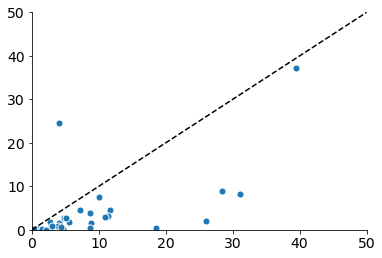

In [8]:
plt.scatter(errs["rlv"]["diff_err"]["diag"], errs["ind"]["avg_err"]["diag"], s=50, edgecolor='white')
lim = 50
plt.plot([0, lim], [0, lim], 'k--')
plt.xlim((0, lim))
plt.ylim((0, lim))

[Text(0, 0, 'pup0'),
 Text(0, 0, 'ind. noise'),
 Text(0, 0, '1-D'),
 Text(0, 0, '2-D')]

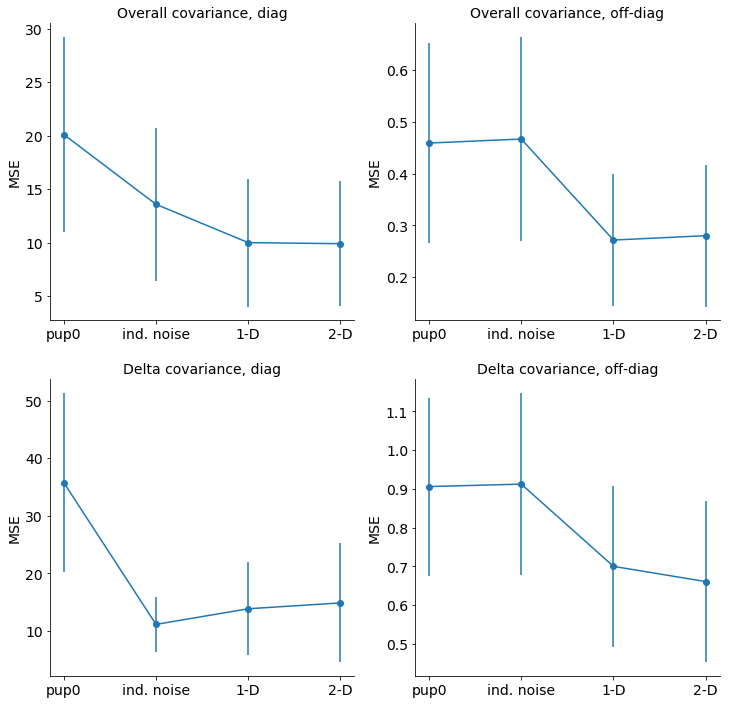

In [11]:
n = len(errs["rlv"]["avg_err"]["diag"])
f, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].errorbar([0, 1, 2, 3], 
                [
                    np.mean(errs["rlv"]["avg_err"]["diag"]),
                    np.mean(errs["ind"]["avg_err"]["diag"]),
                    np.mean(errs["plv"]["avg_err"]["diag"]),
                    np.mean(errs["plv2"]["avg_err"]["diag"]),
                ],
                [
                    np.std(errs["rlv"]["avg_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["ind"]["avg_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["plv"]["avg_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["plv2"]["avg_err"]["diag"]) / np.sqrt(n),
                ],
                marker="o"
                )
ax[0, 0].set_title("Overall covariance, diag", fontsize=14)
ax[0, 0].set_ylabel("MSE")
ax[0, 0].set_xticks(range(0, 4))
ax[0, 0].set_xticklabels(["pup0", "ind. noise", "1-D", "2-D"])

ax[0, 1].errorbar([0, 1, 2, 3], 
                [
                    np.mean(errs["rlv"]["avg_err"]["off"]),
                    np.mean(errs["ind"]["avg_err"]["off"]),
                    np.mean(errs["plv"]["avg_err"]["off"]),
                    np.mean(errs["plv2"]["avg_err"]["off"]),
                ],
                [
                    np.std(errs["rlv"]["avg_err"]["off"]) / np.sqrt(n),
                    np.std(errs["ind"]["avg_err"]["off"]) / np.sqrt(n),
                    np.std(errs["plv"]["avg_err"]["off"]) / np.sqrt(n),
                    np.std(errs["plv2"]["avg_err"]["off"]) / np.sqrt(n),
                ],
                marker="o"
                )
ax[0, 1].set_title("Overall covariance, off-diag", fontsize=14)
ax[0, 1].set_ylabel("MSE")
ax[0, 1].set_xticks(range(0, 4))
ax[0, 1].set_xticklabels(["pup0", "ind. noise", "1-D", "2-D"])

ax[1, 0].errorbar([0, 1, 2, 3], 
                [
                    np.mean(errs["rlv"]["diff_err"]["diag"]),
                    np.mean(errs["ind"]["diff_err"]["diag"]),
                    np.mean(errs["plv"]["diff_err"]["diag"]),
                    np.mean(errs["plv2"]["diff_err"]["diag"]),
                ],
                [
                    np.std(errs["rlv"]["diff_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["ind"]["diff_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["plv"]["diff_err"]["diag"]) / np.sqrt(n),
                    np.std(errs["plv2"]["diff_err"]["diag"]) / np.sqrt(n),
                ],
                marker="o"
                )
ax[1, 0].set_title("Delta covariance, diag", fontsize=14)
ax[1, 0].set_ylabel("MSE")
ax[1, 0].set_xticks(range(0, 4))
ax[1, 0].set_xticklabels(["pup0", "ind. noise", "1-D", "2-D"])

ax[1, 1].errorbar([0, 1, 2, 3], 
                [
                    np.mean(errs["rlv"]["diff_err"]["off"]),
                    np.mean(errs["ind"]["diff_err"]["off"]),
                    np.mean(errs["plv"]["diff_err"]["off"]),
                    np.mean(errs["plv2"]["diff_err"]["off"]),
                ],
                [
                    np.std(errs["rlv"]["diff_err"]["off"]) / np.sqrt(n),
                    np.std(errs["ind"]["diff_err"]["off"]) / np.sqrt(n),
                    np.std(errs["plv"]["diff_err"]["off"]) / np.sqrt(n),
                    np.std(errs["plv2"]["diff_err"]["off"]) / np.sqrt(n),
                ],
                marker="o"
                )
ax[1, 1].set_title("Delta covariance, off-diag", fontsize=14)
ax[1, 1].set_ylabel("MSE")
ax[1, 1].set_xticks(range(0, 4))
ax[1, 1].set_xticklabels(["pup0", "ind. noise", "1-D", "2-D"])

In [10]:
models

{'rlv': 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0',
 'ind': 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.SxR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0',
 'plv': 'psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0',
 'plv2': 'psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0'}

In [14]:
cells, _ = parse_cellid({"batch": 322, "cellid": "TAR010c"})
xf, ctx = load_model_xform(modelname=models["ind"].replace("-epcpn", ""), batch=322, cellid=cells[0], only=slice(0,16), eval_model=False)

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/322/TAR010c/psth.fs4.pup-ld-st.pup0.pvp-hrc-psthfr.z-plgsm.er5-aev.stategain.SxR-spred-lvnor...-9127602475378715133 ...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz to /auto/data/nems_db/recordings/322/TAR010c_910482b5382045b86cc4f0df6106e6e961ba38ba.tgz
[nems.xforms INFO] Extracting cellid(s) ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4

In [45]:
pupil = ctx["val"].apply_mask()["pupil"]._data
pupil = pupil[[0], :int(pupil.shape[1]/8)]

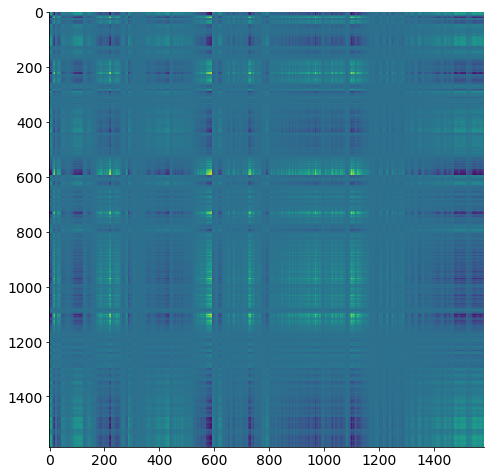

In [46]:
plt.figure(figsize=(8, 8))
plt.imshow(np.outer(pupil, pupil))

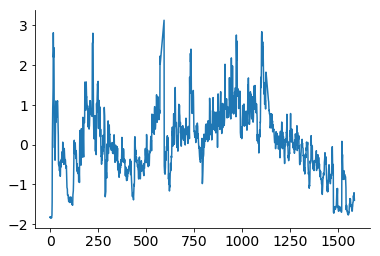

In [47]:
plt.plot(pupil.T)

In [94]:
N = 100
def kernel(a, b, length=1):
    square_distance = np.sum((a - b) ** 2)
    return np.exp(-square_distance / (2 * (length**2)))

cov = np.zeros((N, N))
for ii in range(N):
    for jj in range(N):
        cov[ii, jj] = kernel(ii, jj)

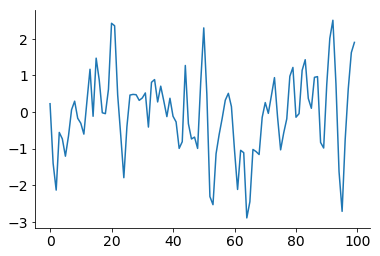

In [95]:
s = np.random.multivariate_normal(np.zeros(N), cov, (1,))
plt.plot(s.T)

/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Text(0.5, 1.0, '1.8198773979916139')

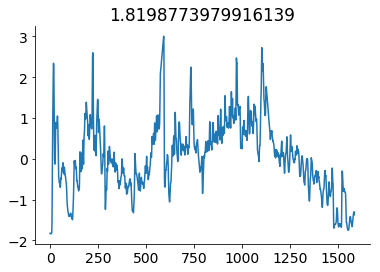

In [141]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import scipy.ndimage.filters as sf

sfull = pupil
s = sf.gaussian_filter1d(sfull, 1)#[[0], 0:-1:15]

kernel = k.RBF(length_scale=10, length_scale_bounds=(1, 100))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(np.atleast_2d(np.linspace(0, sfull.shape[1], s.shape[1])).T, s.T)
x_fine = np.linspace(0, sfull.shape[1], 10000)
y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)
plt.plot(x_fine, y_mean)
plt.title(gp.kernel_.length_scale)

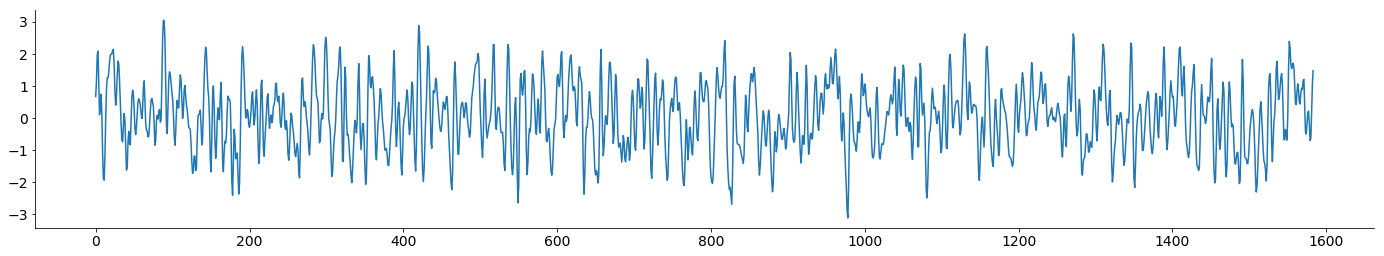

In [146]:
def kernel(a, b, length=1):
    square_distance = np.sum((a - b) ** 2)
    return np.exp(-square_distance / (2 * (length**2)))

N = pupil.shape[1]
cov = np.zeros((N, N))
for ii in range(N):
    for jj in range(N):
        cov[ii, jj] = kernel(ii, jj, length=gp.kernel_.length_scale)

# generate random pupil
s = np.random.multivariate_normal(np.zeros(N), cov, (1,))
plt.figure(figsize=(24, 4))
plt.plot(s.T)

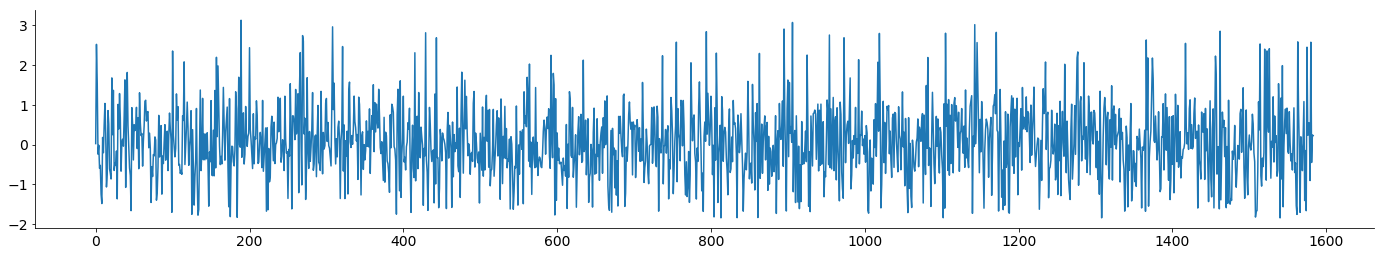

In [145]:
plt.figure(figsize=(24, 4))
plt.plot(np.random.choice(pupil[0], pupil.shape[1], replace=False))

In [155]:
models["rlv"]

'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0'

In [157]:
pupil.shape

(1, 1584)